## Import the MNIST dataset and split into train, val and test

In [1]:
import tensorflow as tf
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np

boundary = 50000
num_classes = 10

X_train = train_images[:boundary, :, :]
y_train = to_categorical(train_labels[:boundary], num_classes=num_classes)

X_val = train_images[boundary:, :, :]
y_val = to_categorical(train_labels[boundary:], num_classes=num_classes)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

print(X_train.dtype)
print(y_train.dtype)

print(y_train[0])

(50000, 28, 28)
(10000, 28, 28)
(50000, 10)
(10000, 10)
uint8
float32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Save the data using TensorFlow protobufs and TFRecord files

### Serialize the image & label

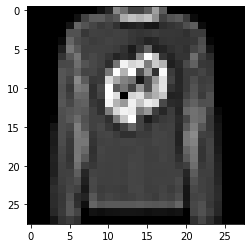

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_image_number = 123

# View the image we are serializing
plt.imshow(X_train[sample_image_number], cmap='gray')
plt.show()

In [4]:
print('Sample image label = ', y_train[sample_image_number])

image_tensors = []
for image in X_train:
    image_tensors.append(tf.io.serialize_tensor(tensor = image))
    
label_tensors = []
for label in y_train:
    label_tensors.append(tf.io.serialize_tensor(tensor = label))

print('# of serialized images = ', len(image_tensors))
print('# of serialized labels = ', len(label_tensors))

Sample image label =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
# of serialized images =  50000
# of serialized labels =  50000


### Define the the protobuf

In [5]:
from tensorflow.compat.v2.train import Feature, Features, Example, BytesList, FloatList

images_as_bytes = []
labels_as_bytes = []
for image_tensor, label_tensor in zip(image_tensors, label_tensors):
    images_as_bytes.append(BytesList(value=[image_tensor.numpy()])) # Convert image to bytes list
    labels_as_bytes.append(BytesList(value=[label_tensor.numpy()])) # Convert label to bytes list

protobuf_data = []
for image, label in zip(images_as_bytes, labels_as_bytes):
    protobuf_data.append(Example(
        features = Features(
            feature={
                'image': Feature(bytes_list = image),
                'label': Feature(bytes_list = label)
            }
        )
    ))

In [6]:
# print(protobuf_data[sample_image_number])

## Write the records to file

In [7]:
with tf.io.TFRecordWriter('my_records.tfrecord') as f:
    for data in protobuf_data:
        f.write(data.SerializeToString())

## Read the records from file

### Define what the protobuf entries are

In [8]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string)
}

### Read in the data

In [9]:
read_images = []
read_labels = []
for serialized_example in tf.data.TFRecordDataset(['my_records.tfrecord']):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    read_images.append(tf.io.parse_tensor(parsed_example['image'], out_type=tf.uint8))
    read_labels.append(tf.io.parse_tensor(parsed_example['label'], out_type=tf.float32))

### Check the image and label read from file are correct

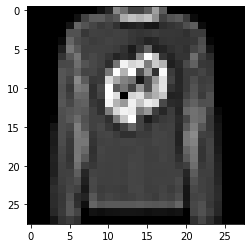

example label =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
import matplotlib.pyplot as plt

plt.imshow(read_images[sample_image_number], cmap='gray')
plt.show()

print('example label = ', read_labels[sample_image_number].numpy())